1 REGRESSION LINEAIRE

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('WineQT.csv')

VISUALISATION DES DONNEES

Nous commençons par une étape de visualisation des données. Cette étape nous permet de voir la distribution de nos données.

In [40]:
def plot_hists(df):
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))
    for n in range(12):
        i = n % 3
        j = n % 4
        ax[i, j].hist(df.iloc[:, n], bins='auto')
        ax[i, j].set_xlabel(df.columns[n])

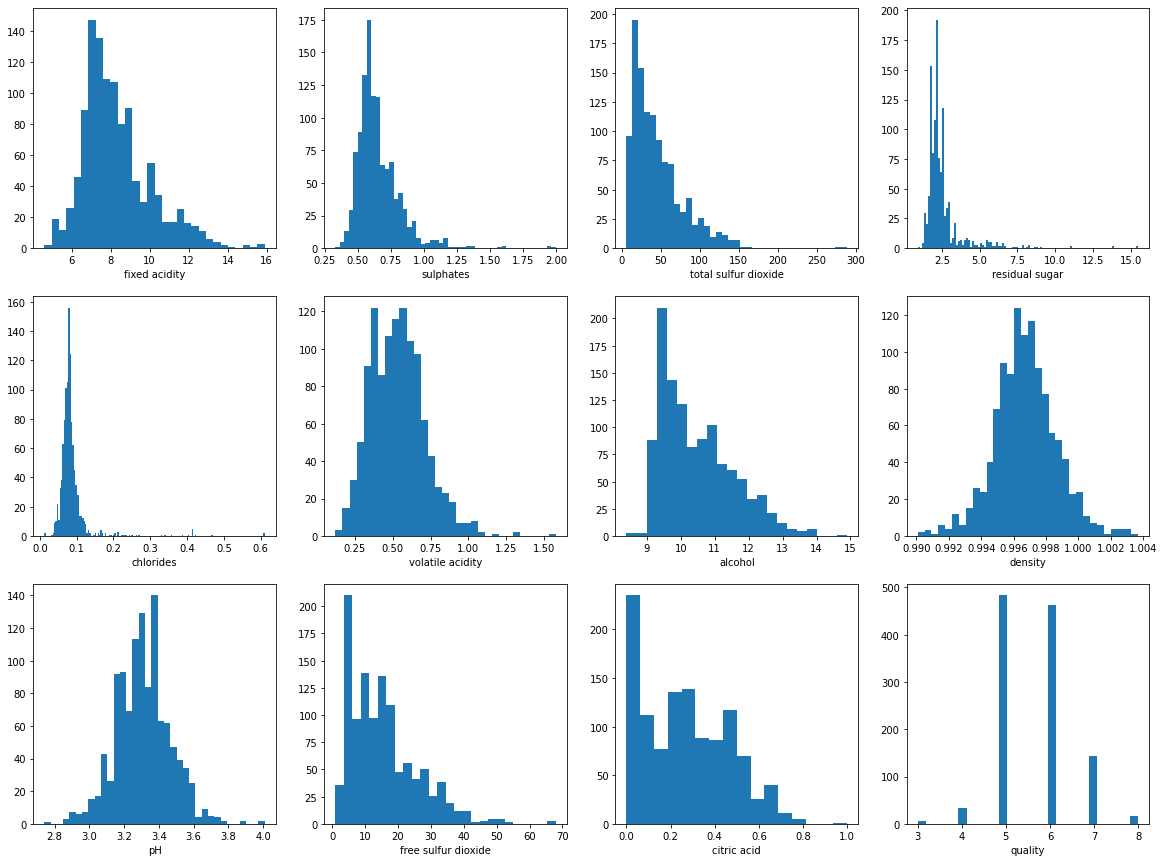

In [41]:
plot_hists(df)

Grâce à cette visualisation, nous modifions les colonnes qui ne semblent pas avoir une distribution normale.
On normalise avec un paramètre trouvé à la main pour chaque caractéristique et on standardise.

c:\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


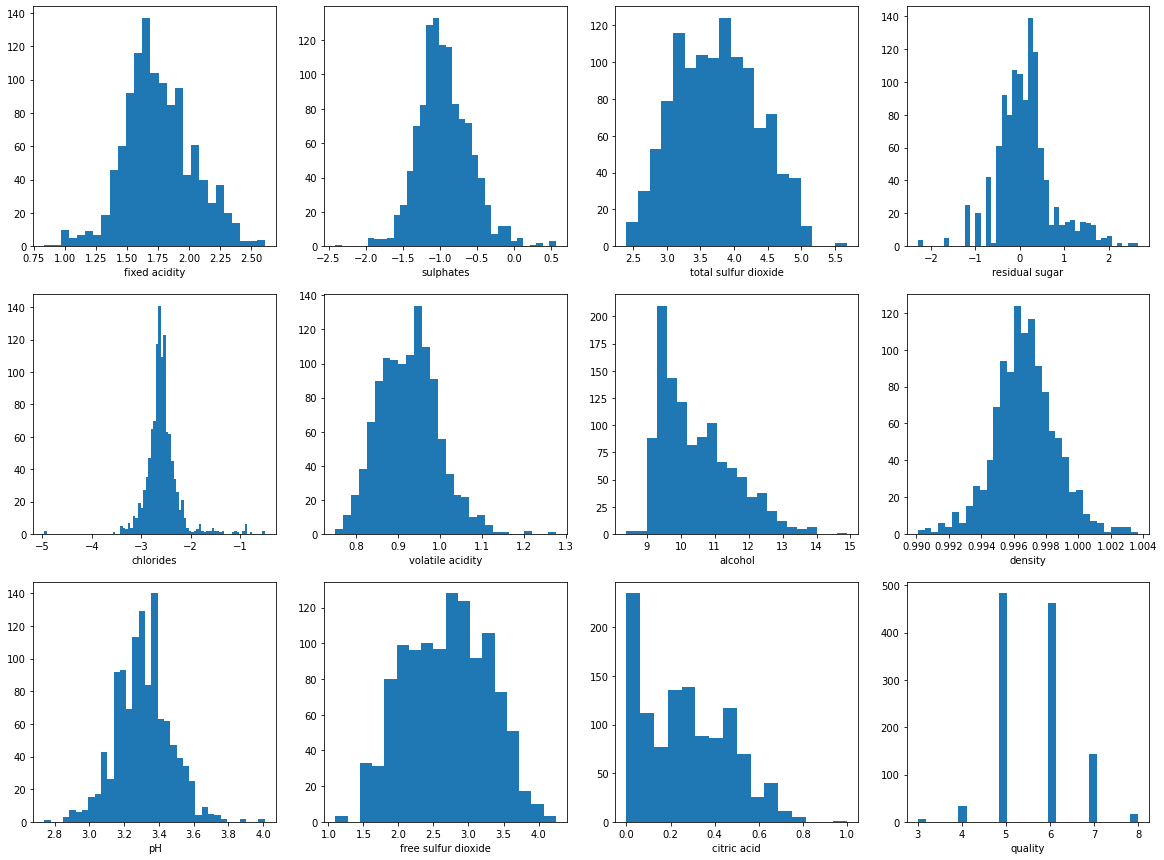

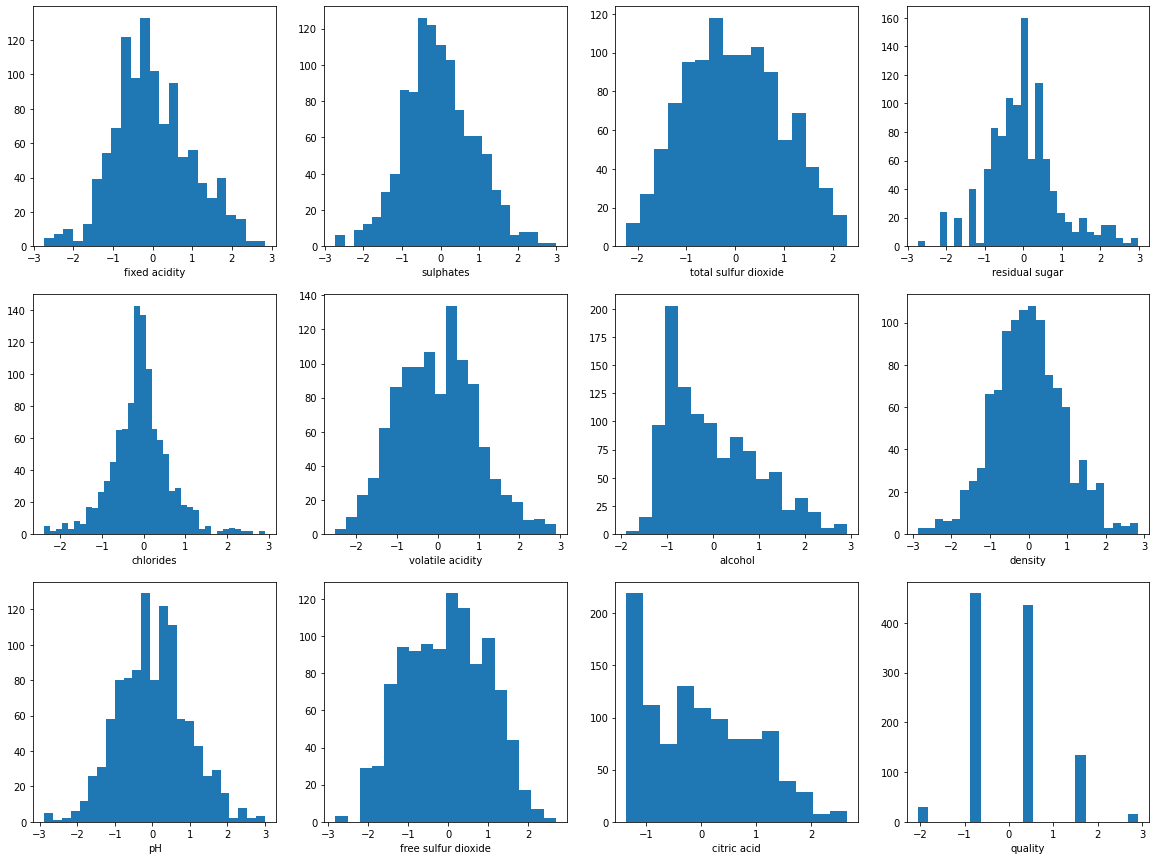

In [52]:
#mettre entre 0 et 1
def normalize(df, property, parameter):
    df[property] = np.log(df[property] + parameter)

normalize(df, "fixed acidity", -2.3)
normalize(df, "sulphates", -0.24)
normalize(df, "total sulfur dioxide", 5)
normalize(df, "residual sugar", -1.1)
normalize(df, "chlorides", -0.005)
normalize(df, "volatile acidity", 2)
normalize(df, "free sulfur dioxide", 2)
plot_hists(df)

#moyenne en 0 et écart type de 1( valeur entre -3 et 3)
standardized = (df - df.mean()) / df.std()
standardized = standardized[(np.abs(standardized) < 3).all(axis=1)]
plot_hists(standardized)
df=standardized

Souhaitant prédire la qualité, nous allons afficher les graph des différentes caractéristiques en fonction de la qualité, ainsi qu'une matrice de corrélation linéaire.

<Axes: >

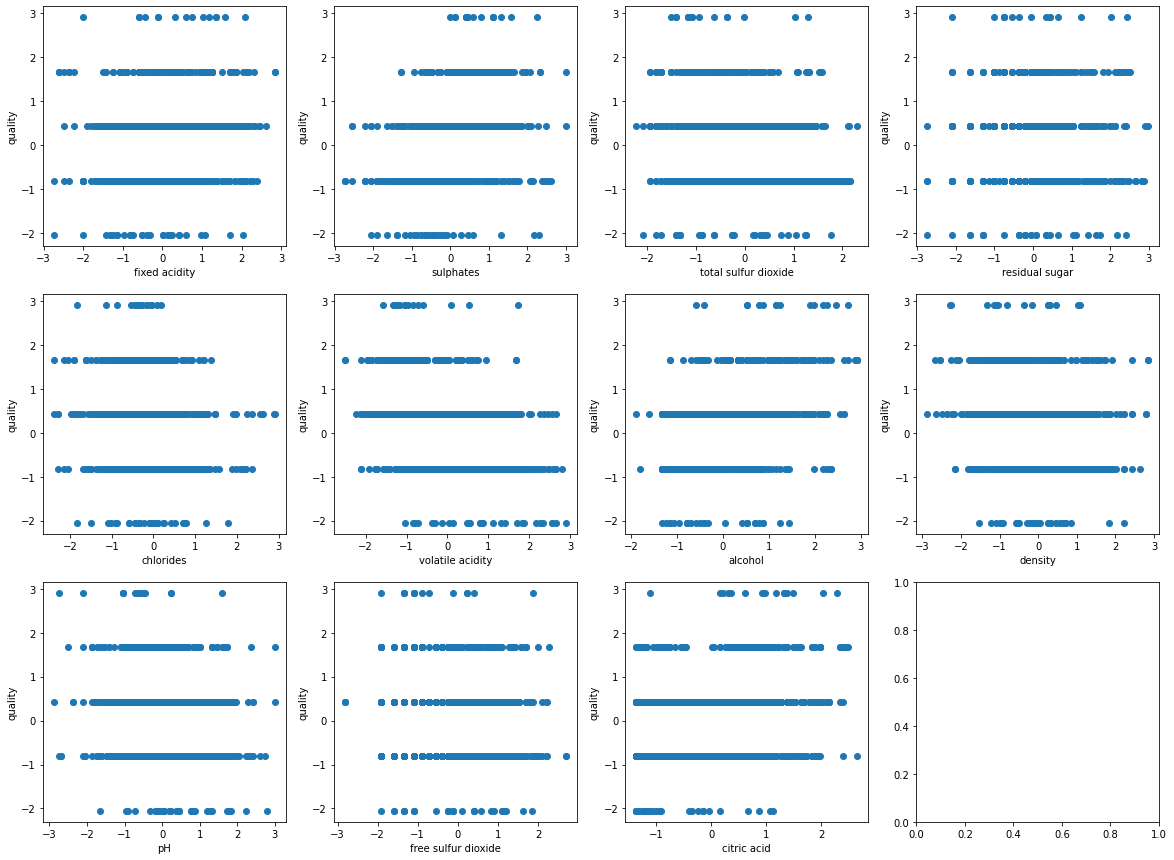

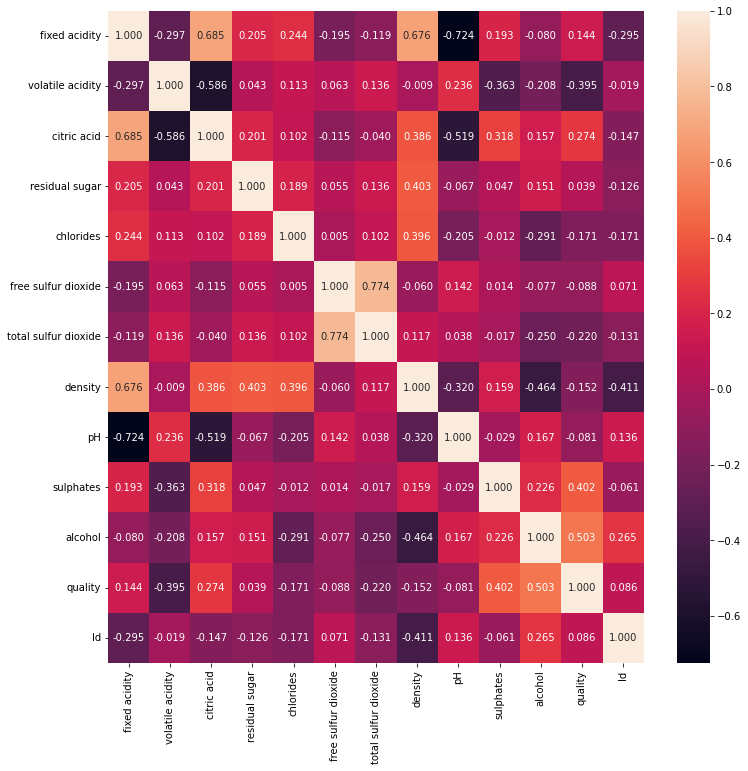

In [59]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))
for n in range(11):
    i = n % 3
    j = n % 4
    ax[i, j].scatter(df.iloc[:, n], df['quality'])
    ax[i, j].set_xlabel(df.columns[n])
    ax[i, j].set_ylabel('quality')

import seaborn as sns

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))
correlation = df.corr()
sns.heatmap(correlation, annot=True, fmt='.3f')

Certaines caractéristiques sont particulièrement corrélées. Mais on ne détecte rien de très intéressant pour la qualité. Le coefficient R ne dépassant jamais 0.5, on va garder toutes les données et continuer.

PREMIERE METHODE : POSED LINEAR PROBLEM

Nous allons pour cette première méthode traiter la question comme une régression linéaire.
On aura donc quality = w1*fixe_acidity + w2* volatile_acidity+ ... + w10*sulphates + b

Préparation des données :

In [63]:
import numpy as np
import matplotlib.pyplot as plt
# load the dataset

print(df)
y_train = df['quality']
X_train= [df['fixed acidity'],  df['volatile acidity']  ,df['citric acid']  ,df['residual sugar'],  df['chlorides'],df['free sulfur dioxide']  ,df['total sulfur dioxide'],  df['density']    ,df['pH'],  df['sulphates']]
X_features = ['fixed acidity',  'volatile acidity'  ,'citric acid'  ,'residual sugar',  'chlorides','free sulfur dioxide'  ,'total sulfur dioxide',  'density'    ,'pH',  'sulphates']
X_train=np.transpose(np.asmatrix(X_train))
y_train=np.asarray(y_train)
nb_feature=len(X_features)

print(y_train)
print("nombre d'observations X: ",len(X_train))
print("nombre d'observations y: ",len(y_train))
# fig,ax=plt.subplots(1, nb_feature, figsize=(30, 5), sharey=True)
# for i in range(len(ax)):
#     ax[i].scatter([X_train[:,i]],[y_train])
#     ax[i].set_xlabel(X_features[i])
# ax[0].set_ylabel("Quality")
# plt.show()





      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0         -0.449730          0.959130    -1.364429       -0.552408  -0.190766   
1         -0.178276          1.883541    -1.364429        0.439229   0.583043   
2         -0.178276          1.273943    -1.161059        0.087218   0.391851   
3          1.552041         -1.462616     1.482750       -0.552408  -0.231431   
4         -0.449730          0.959130    -1.364429       -0.552408  -0.190766   
...             ...               ...          ...             ...        ...   
1138      -1.323138         -0.086034    -0.703477        0.087218  -0.190766   
1139      -0.899700          0.528319    -0.957689       -0.552408  -0.533480   
1140      -1.414157          0.418561    -0.957689       -0.366604   0.325178   
1141      -1.701916          0.140428    -0.856004       -0.050044  -0.820400   
1142      -1.701916          0.664345    -0.754319       -0.366604  -0.231431   

      free sulfur dioxide  

NOUVELLE MODIFICATION DU JEU DE DONNEES :

on a trop de vins de qualité égales à 5 ou 6... le modèle pourrait se concentrer sur des notes de 5 et 6 pour que la somme des erreures soit minimale. On va donc modifier le jeu de données pour avoir une répartition plus homogène.

[[-0.44973019  0.95913034 -1.36442937 ...  0.55561117  1.27013897
  -0.57188487]
 [-0.17827559  1.88354092 -1.36442937 ...  0.03614877 -0.70861736
   0.33451607]
 [-0.17827559  1.27394285 -1.16105938 ...  0.14004125 -0.32563227
   0.13352038]
 ...
 [-1.41415681  0.41856081 -0.95768939 ... -0.9508298   0.88715387
  -0.39933166]
 [-1.70191559  0.14042794 -0.8560044  ... -0.83654807  1.33396982
   0.80999482]
 [-1.70191559  0.66434478 -0.7543194  ... -0.65473623  1.65312406
   0.52224935]]
(369,)
(840, 10)


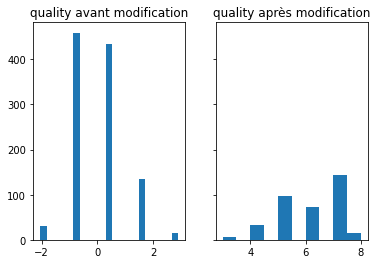

In [68]:
import random
X_norm=X_train
print(X_norm)
fig,ax=plt.subplots(1,2,sharey=True)
ax[0].hist(df["quality"], bins='auto',label="quality")
ax[0].set_title("quality avant modification")
supp=[]
#on supprime aleatoirement des valeurs de notes 5 et 6 (diviser par 3)
for i in range(len(y_train)):
    if y_train[i]==5 or y_train[i]==6:
        rand=random.random()
        if(rand>0.4):
            supp.append(i)
for j in range(len(supp)):
    y_train2=np.delete(y_train,supp)
    X_norm2=np.delete(X_norm,supp,0)


ax[1].hist(y_train2, bins='auto',label="quality")
ax[1].set_title("quality après modification")

print(y_train2.shape)
print(X_norm2.shape)
X_norm=X_norm2
y_train=y_train2

DESCENTE DE GRADIENT : 

Pour trouver les bons coefficients de la régression linéaire, nous allons utiliser la méthode de la descente de gradient en calculant le cout via les moindre carrés.

Codes

In [65]:
import copy
import math


def compute_cost(X, y, w, b): 
    """
    compute cost
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters  
      b (scalar)       : model parameter
      
    Returns:
      cost (scalar): cost
    """
    m = X.shape[0]
    
    cost = 0.0
    for i in range(m):                                
        f_wb_i = np.dot(X[i], w) + b           #(n,)(n,) = scalar (see np.dot)
        cost = cost + (f_wb_i - y[i])**2       #scalar
    cost = cost / (2 * m)                      #scalar    
    return cost

def compute_gradient(X, y, w, b): 
    """
    Computes the gradient for linear regression 
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters  
      b (scalar)       : model parameter
      
    Returns:
      dj_dw (ndarray (n,)): The gradient of the cost w.r.t. the parameters w. 
      dj_db (scalar):       The gradient of the cost w.r.t. the parameter b. 
    """
    m,n = X.shape           #(number of examples, number of features)
    dj_dw = np.zeros((n,))
    dj_db = 0.

    for i in range(m):                    
        err = (np.dot(X[i], w) + b) - y[i]   
        for j in range(n):                      
            dj_dw[j] = dj_dw[j] + err * X[i, j]    
        dj_db = dj_db + err                        
    dj_dw = dj_dw / m                                
    dj_db = dj_db / m                                
        
    return dj_db, dj_dw

def gradient_descent(X, y, w_in, b_in, alpha, num_iters): 
    """
    Performs batch gradient descent to learn w and b. Updates w and b by taking 
    num_iters gradient steps with learning rate alpha
    
    Args:
      X (ndarray (m,n))   : Data, m examples with n features
      y (ndarray (m,))    : target values
      w_in (ndarray (n,)) : initial model parameters  
      b_in (scalar)       : initial model parameter
      cost_function       : function to compute cost
      gradient_function   : function to compute the gradient
      alpha (float)       : Learning rate
      num_iters (int)     : number of iterations to run gradient descent
      
    Returns:
      w (ndarray (n,)) : Updated values of parameters 
      b (scalar)       : Updated value of parameter 
      """
    
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w = copy.deepcopy(w_in)  #avoid modifying global w within function
    b = b_in
    
    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db,dj_dw = compute_gradient(X, y, w, b)   ##None

        # Update Parameters using w, b, alpha and gradient
        w = w - alpha * dj_dw               ##None
        b = b - alpha * dj_db               ##None
      
        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            J_history.append( compute_cost(X, y, w, b))

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters / 10) == 0:
            
           print("Iteration", i,": Cost ", J_history[-1])
        
    return w, b, np.squeeze(J_history) #return final w,b and J history for graphing

Application:

In [70]:

print(X_norm.shape)
print(y_train.shape)
b_init = 0
w_init = np.array([ 0,0,0,0,0,0,0,0,0,0])
print(f"w_init shape: {w_init.shape}, b_init type: {type(b_init)}")
initial_w = np.zeros_like(w_init)
initial_b = 0.
X_norm=np.array(X_norm)
print(X_norm)
print(y_train)


compute_cost(X_norm, y_train, initial_w, initial_b)

(840, 10)
(369,)
w_init shape: (10,), b_init type: <class 'int'>
[[-0.17827559  1.88354092 -1.36442937 ...  0.03614877 -0.70861736
   0.33451607]
 [-0.17827559  1.27394285 -1.16105938 ...  0.14004125 -0.32563227
   0.13352038]
 [ 1.55204092 -1.46261632  1.4827505  ...  0.65950365 -0.96394076
  -0.39933166]
 ...
 [-1.41415681  0.41856081 -0.95768939 ... -0.9508298   0.88715387
  -0.39933166]
 [-1.70191559  0.14042794 -0.8560044  ... -0.83654807  1.33396982
   0.80999482]
 [-1.70191559  0.66434478 -0.7543194  ... -0.65473623  1.65312406
   0.52224935]]
[5 6 5 5 7 7 7 6 5 5 6 6 7 4 5 4 5 5 4 6 4 5 4 5 5 5 5 6 5 7 6 6 6 4 5 4 5
 5 4 4 5 6 5 5 4 7 7 7 5 5 6 7 6 7 7 6 7 4 4 8 6 8 7 7 7 7 7 6 5 5 7 7 7 7
 7 6 7 7 6 7 7 7 7 6 8 5 7 5 7 4 6 7 6 7 7 7 7 8 7 7 7 5 8 3 6 5 5 8 5 7 7
 8 8 7 7 7 7 7 7 7 7 5 3 6 5 6 5 7 5 5 6 6 6 5 6 6 4 5 7 8 6 5 5 5 4 5 4 7
 7 5 5 6 5 5 5 5 6 6 6 4 4 5 5 5 6 5 5 5 6 6 5 6 5 5 5 6 5 7 7 7 6 6 4 6 5
 7 5 5 7 4 4 7 7 7 6 5 6 6 7 7 4 7 6 6 7 7 5 7 7 7 6 6 7 4 5 7 5 7 7

IndexError: index 369 is out of bounds for axis 0 with size 369

w_init shape: (10,), b_init type: <class 'int'>
[[ 7.8      0.88     0.      ...  0.9968   3.2      0.68   ]
 [ 7.8      0.76     0.04    ...  0.997    3.26     0.65   ]
 [11.2      0.28     0.56    ...  0.998    3.16     0.58   ]
 ...
 [ 6.3      0.51     0.13    ...  0.99574  3.42     0.75   ]
 [ 6.8      0.62     0.08    ...  0.99651  3.42     0.82   ]
 [ 5.9      0.645    0.12    ...  0.99547  3.57     0.71   ]]
Iteration 0 : Cost  75820.9928912077
Iteration 20 : Cost  6.833604582731018e+81
Iteration 40 : Cost  6.159240233142674e+158
Iteration 60 : Cost  5.551424550584978e+235
Iteration 80 : Cost  inf
Iteration 100 : Cost  inf


C:\Users\hbailleux\AppData\Local\Temp\ipykernel_1244\1263849773.py:22: RuntimeWarning: overflow encountered in double_scalars
  cost = cost + (f_wb_i - y[i])**2       #scalar


Iteration 120 : Cost  inf
Iteration 140 : Cost  inf
Iteration 160 : Cost  nan


C:\Users\hbailleux\AppData\Local\Temp\ipykernel_1244\1263849773.py:46: RuntimeWarning: overflow encountered in double_scalars
  dj_dw[j] = dj_dw[j] + err * X[i, j]
C:\Users\hbailleux\AppData\Local\Temp\ipykernel_1244\1263849773.py:46: RuntimeWarning: invalid value encountered in double_scalars
  dj_dw[j] = dj_dw[j] + err * X[i, j]
C:\Users\hbailleux\AppData\Local\Temp\ipykernel_1244\1263849773.py:84: RuntimeWarning: invalid value encountered in subtract
  w = w - alpha * dj_dw               ##None


Iteration 180 : Cost  nan
b,w found by gradient descent: nan,[nan nan nan nan nan nan nan nan nan nan] 
prediction: nan, target value: 5
prediction: nan, target value: 5
prediction: nan, target value: 6
prediction: nan, target value: 5
prediction: nan, target value: 5
prediction: nan, target value: 5
prediction: nan, target value: 7
prediction: nan, target value: 7
prediction: nan, target value: 5
prediction: nan, target value: 7
prediction: nan, target value: 6
prediction: nan, target value: 5
prediction: nan, target value: 5
prediction: nan, target value: 5
prediction: nan, target value: 5
prediction: nan, target value: 5
prediction: nan, target value: 6
prediction: nan, target value: 6
prediction: nan, target value: 7
prediction: nan, target value: 4
prediction: nan, target value: 5
prediction: nan, target value: 4
prediction: nan, target value: 5
prediction: nan, target value: 5
prediction: nan, target value: 5
prediction: nan, target value: 5
prediction: nan, target value: 5
predi

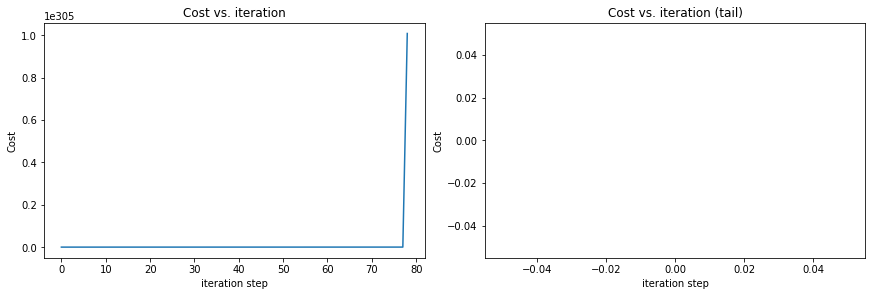

In [58]:
# initialize parameters
b_init = 0
w_init = np.array([ 0,0,0,0,0,0,0,0,0,0])
print(f"w_init shape: {w_init.shape}, b_init type: {type(b_init)}")
initial_w = np.zeros_like(w_init)
initial_b = 0.
# gradient descent settings
iterations = 200
alpha = 2.5e-2
# run gradient descent 
print(X_norm)
w_final, b_final, J_hist = gradient_descent(X_norm, y_train, initial_w, initial_b,alpha, iterations)
print(f"b,w found by gradient descent: {b_final},{w_final} ")
m,_ = X_norm.shape
for i in range(m):
    print(f"prediction: {np.dot(X_norm[i], w_final) + b_final}, target value: {y_train[i]}")

print(J_hist)
# plot cost versus iteration  
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))
ax1.plot(J_hist)
ax2.plot(100 + np.arange(len(J_hist[100:])), J_hist[100:])
ax1.set_title("Cost vs. iteration");  ax2.set_title("Cost vs. iteration (tail)")
ax1.set_ylabel('Cost')             ;  ax2.set_ylabel('Cost') 
ax1.set_xlabel('iteration step')   ;  ax2.set_xlabel('iteration step') 
plt.show()



La descente de gradient nous donne les coefficients de la régression linéaire qui minimise l'erreur.

INFLUENCE DE L'HYPERPARAMETRE ALPHA

Alpha est l'hyperparamètre de la descente de gradient qui met à jour les coefficients de la regression à chaque itération. Plus alpha sera grand, plus l'ajustement sera important.

Iteration 0 : Cost  [[4.37456967]]
Iteration 20 : Cost  [[0.29471549]]
Iteration 40 : Cost  [[0.29416983]]
Iteration 60 : Cost  [[0.2941102]]
Iteration 80 : Cost  [[0.2941027]]
Iteration 100 : Cost  [[0.29410175]]
Iteration 120 : Cost  [[0.29410163]]
Iteration 140 : Cost  [[0.29410161]]
Iteration 160 : Cost  [[0.29410161]]
Iteration 180 : Cost  [[0.29410161]]
Iteration 0 : Cost  [[17.41857173]]
Iteration 20 : Cost  [[14.03465461]]
Iteration 40 : Cost  [[11.37148066]]
Iteration 60 : Cost  [[9.2569901]]
Iteration 80 : Cost  [[7.56723244]]
Iteration 100 : Cost  [[6.21026498]]
Iteration 120 : Cost  [[5.11637118]]
Iteration 140 : Cost  [[4.23182357]]
Iteration 160 : Cost  [[3.51471957]]
Iteration 180 : Cost  [[2.9320872]]


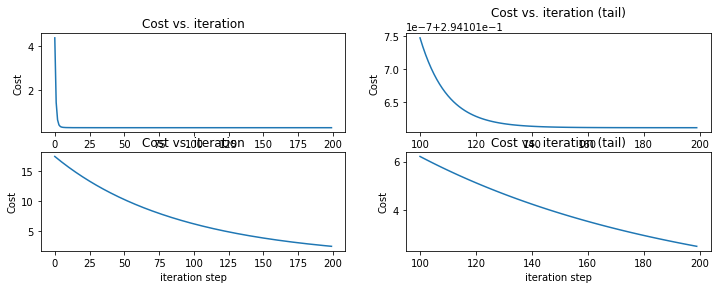

In [118]:
alpha1 = 5.0e-1
alpha2 = 5.0e-3
fig, [[ax1,ax2],[ax3,ax4]]= plt.subplots(nrows=2, ncols=2, figsize=(12, 4))
w_final1, b_final1, J_hist1 = gradient_descent(X_norm, y_train, initial_w, initial_b,alpha1, iterations)
w_final2, b_final2, J_hist2 = gradient_descent(X_norm, y_train, initial_w, initial_b,alpha2, iterations)



ax1.plot(J_hist1)
ax2.plot(100 + np.arange(len(J_hist1[100:])), J_hist1[100:])
ax1.set_title("Cost vs. iteration");  ax2.set_title("Cost vs. iteration (tail)")
ax1.set_ylabel('Cost')             ;  ax2.set_ylabel('Cost') 
ax1.set_xlabel('iteration step')   ;  ax2.set_xlabel('iteration step') 

ax3.plot(J_hist2)
ax4.plot(100 + np.arange(len(J_hist2[100:])), J_hist2[100:])
ax3.set_title("Cost vs. iteration");  ax4.set_title("Cost vs. iteration (tail)")
ax3.set_ylabel('Cost')             ;  ax4.set_ylabel('Cost') 
ax3.set_xlabel('iteration step')   ;  ax4.set_xlabel('iteration step') 
plt.show()

Le premier alpha est trop grand, on risque de sauter l'optimum. Le second est trop petit, on ne l'atteint qu'après un trop grand nombre d'itérations...

TEST DU RESULTAT: Après avoir trouver nos coefficients permettant de minimiser l'erreur, on peut visualiser nos prédictions.

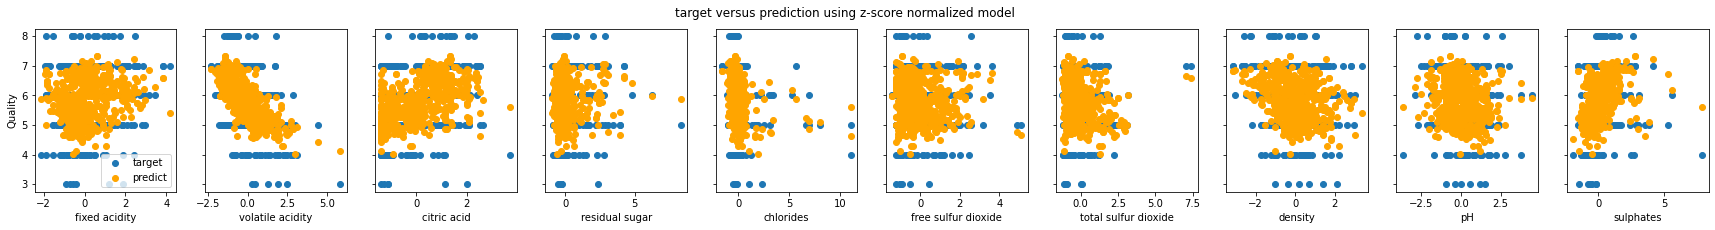

In [122]:
#predict target using normalized features
m = X_norm.shape[0]
yp = np.zeros(m)
for i in range(m):
    yp[i] = np.dot(X_norm[i], w_final) + b_final

    # plot predictions and targets versus original features    
fig,ax=plt.subplots(1,nb_feature,figsize=(30, 3),sharey=True)
for i in range(len(ax)):
    ax[i].scatter([X_norm[:,i]],y_train, label = 'target')
    ax[i].set_xlabel(X_features[i])
    ax[i].scatter([X_norm[:,i]],yp,color="orange", label = 'predict')
ax[0].set_ylabel("Quality"); ax[0].legend()
fig.suptitle("target versus prediction using z-score normalized model")
plt.show()

Le résultat ne parait pas très bon. La régression linéaire n'est pas adaptée car on doit trouver des valeurs discrètes.